In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV



In [21]:
class ASP(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=1.0, rho=0.5, a=3.0, max_iter=100, tol=1e-4):
        self.alpha = alpha
        self.rho = rho
        self.a = a
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = 0.0
    
    def _mcp_derivative(self, beta):
        lambda1 = self.alpha * self.rho
        deriv = np.zeros_like(beta)
        abs_beta = np.abs(beta)
        idx = abs_beta <= self.a * lambda1
        deriv[idx] = -lambda1 * np.sign(beta[idx]) * (1 - abs_beta[idx] / (self.a * lambda1))
        return deriv

    def fit(self, X, y):
        X_mean = np.mean(X, axis=0)
        y_mean = np.mean(y)
        X_centered = X - X_mean
        y_centered = y - y_mean
        
        n, p = X.shape
        beta = np.zeros(p)
        XtX_n = X_centered.T @ X_centered / n
        Xty_n = X_centered.T @ y_centered / n
        
        for _ in range(self.max_iter):
            beta_old = beta.copy()
            mcp_grad = self._mcp_derivative(beta)
            
            for j in range(p):
                if XtX_n[j, j] < 1e-10:
                    continue
                l_j = np.dot(XtX_n[j, :], beta) - XtX_n[j, j] * beta[j] - Xty_n[j] + mcp_grad[j]
                beta[j] = -np.sign(l_j) * max(0, abs(l_j) - self.alpha * (1 - self.rho)) / XtX_n[j, j]
            
            if np.linalg.norm(beta - beta_old) < self.tol:
                break
        
        self.coef_ = beta
        self.intercept_ = y_mean - np.dot(X_mean, beta)
        return self

    def predict(self, X):
        return X @ self.coef_ + self.intercept_

    def score(self, X, y):
        return r2_score(y, self.predict(X))


In [6]:
dataset=pd.read_csv('./StudentPerformanceFactors.csv')
dataset.columns


Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender',
       'Exam_Score'],
      dtype='object')

In [7]:
dataset

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,68
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,69
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,68
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,68


In [8]:
dataset['Parental_Education_Level'].unique()

array(['High School', 'College', 'Postgraduate', nan], dtype=object)

In [9]:
priority_map_1 = {'High': 2, 'Medium': 1, 'Low': 0}
priority_map_2 = {'Yes': 1, 'No': 0}
priority_map_3 = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
priority_map_4 = {'Private': 1, 'Public': 0}
priority_map_5 = {'High School': 2, 'College': 1, 'Postgraduate': 0}
priority_map_6 = {'Near': 2, 'Moderate': 1, 'Far': 0}
priority_map_7 = {'Male': 1, 'Female': 0}
dataset['Parental_Involvement'] = dataset['Parental_Involvement'].map(priority_map_1)
dataset['Access_to_Resources'] = dataset['Access_to_Resources'].map(priority_map_1)
dataset['Extracurricular_Activities'] = dataset['Extracurricular_Activities'].map(priority_map_2)
dataset['Motivation_Level'] = dataset['Motivation_Level'].map(priority_map_1)
dataset['Internet_Access'] = dataset['Internet_Access'].map(priority_map_2)
dataset['Family_Income'] = dataset['Family_Income'].map(priority_map_1)
dataset['Teacher_Quality'] = dataset['Teacher_Quality'].map(priority_map_1)
dataset['School_Type'] = dataset['School_Type'].map(priority_map_4)
dataset['Peer_Influence'] = dataset['Peer_Influence'].map(priority_map_3)
dataset['Learning_Disabilities'] = dataset['Learning_Disabilities'].map(priority_map_2)
dataset['Parental_Education_Level'] = dataset['Parental_Education_Level'].map(priority_map_5)
dataset['Distance_from_Home'] = dataset['Distance_from_Home'].map(priority_map_6)
dataset['Gender'] = dataset['Gender'].map(priority_map_7)


In [10]:
dataset.isna().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

In [11]:
# Drop NA values of Price, since it's our predictive variable we won't impute it
dataset.dropna(inplace=True)

In [58]:
len(dataset.columns)

20

In [50]:
dataset = pd.get_dummies(dataset, drop_first=True).astype(int)

In [12]:
dataset.shape

(6378, 20)

In [61]:
dataset.columns

Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender',
       'Exam_Score'],
      dtype='object')

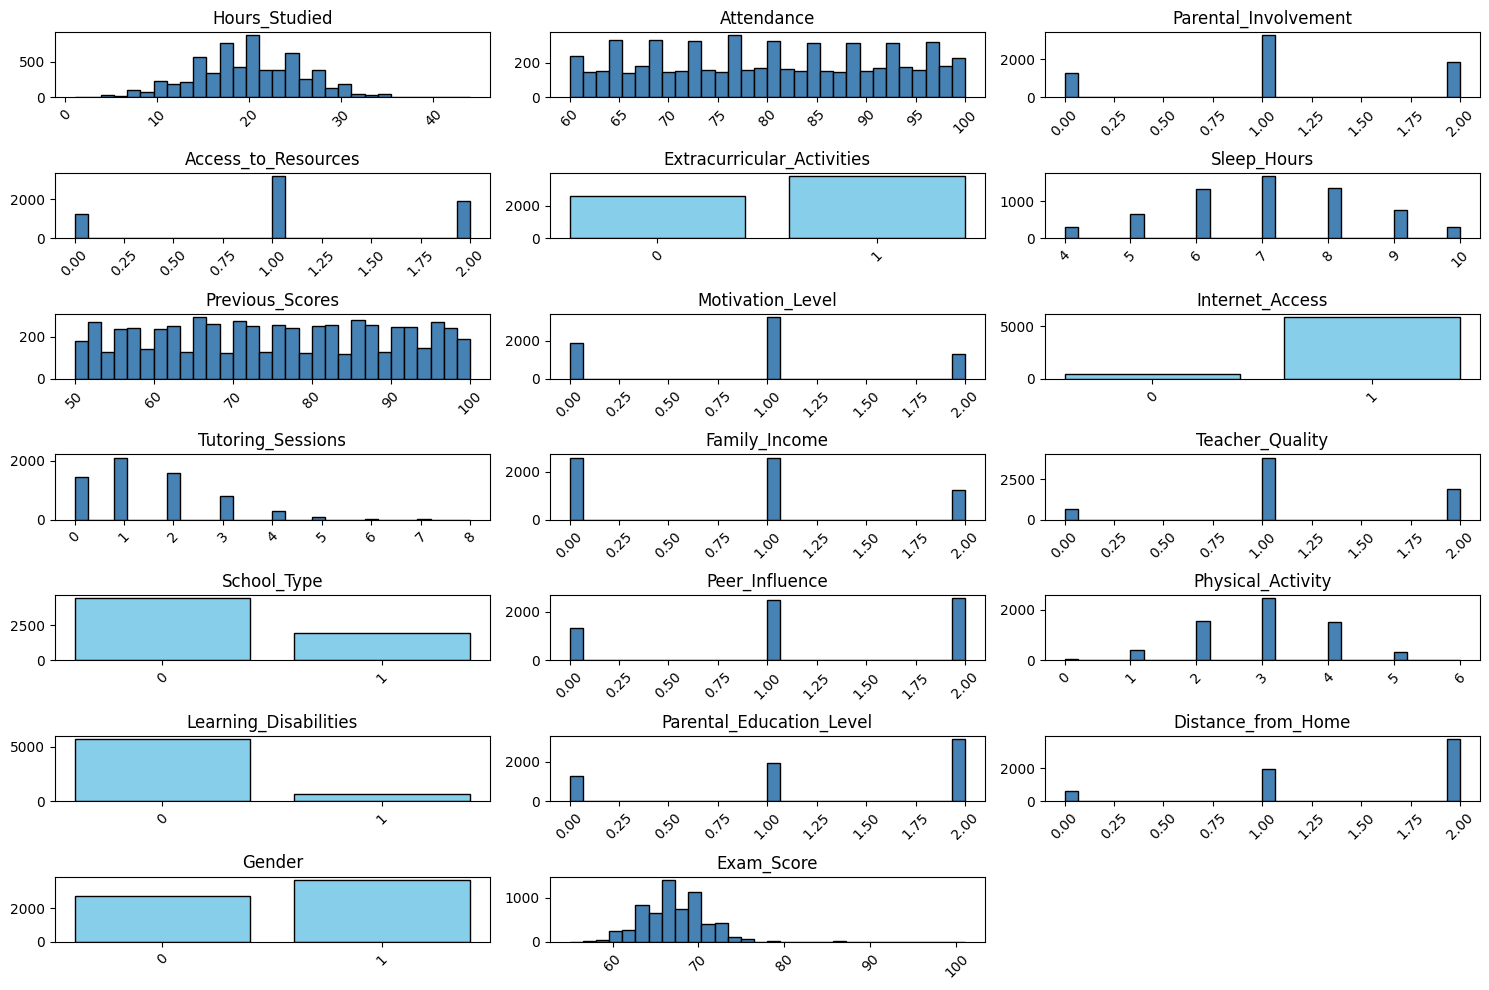

In [22]:
df=dataset
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = 3
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    unique_vals = df[col].dropna().unique()
    
    if set(unique_vals).issubset({0, 1}):
        counts = df[col].value_counts().sort_index()
        axes[i].bar(counts.index.astype(str), counts.values, color='skyblue', edgecolor='black')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['0', '1'])
    else:
        axes[i].hist(df[col], bins=30, color='steelblue', edgecolor='black')

    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [63]:
dataset.describe

<bound method NDFrame.describe of       Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
0                23          84                     0                    2   
1                19          64                     0                    1   
2                24          98                     1                    1   
3                29          89                     0                    1   
4                19          92                     1                    1   
...             ...         ...                   ...                  ...   
6602             25          69                     2                    1   
6603             23          76                     2                    1   
6604             20          90                     1                    0   
6605             10          86                     2                    2   
6606             15          67                     1                    0   

      Extracurricular_Activit

In [23]:
def RealDataModelling(prediction):
    # Load and prepare data
    # california = fetch_california_housing()
    # X, y = california.data, california.target
    # feature_names = california.feature_names
    X = dataset.drop(prediction, axis=1)
    y = dataset[prediction]
    feature_names = dataset.columns
    # # Train-test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models to compare
    models = {
        'LASSO': Lasso(),
        'MCP (ρ=0.9)': ASP(rho=0.9),  # MCP approximation
        'ASP (ρ=0.1)': ASP(rho=0.1),
        'ASP (ρ=0.3)': ASP(rho=0.3),
        'ASP (ρ=0.5)': ASP(rho=0.5),
        'ASP (ρ=0.7)': ASP(rho=0.7),
        'ASP (ρ=0.9)': ASP(rho=0.9)
    }

    # Parameter grids for tuning
    param_grids = {
        'LASSO': {'alpha': np.logspace(-3, 1, 20)},
        'MCP (ρ=0.9)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.1)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.3)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.5)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.7)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.9)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]}
    }

    # Results storage
    results = []

# Train and evaluate each model
    for name in models:
        print(f"\nTraining {name}...")
        start_time = time.time()
        gs = GridSearchCV(models[name], param_grids[name], cv=5, scoring='neg_mean_squared_error')
        gs.fit(X_train_scaled, y_train)
        
        end_time = time.time()
        training_time = end_time - start_time
        best = gs.best_estimator_
        y_pred = best.predict(X_test_scaled)
        
        results.append({
            'Model': name,
            'Best Params': gs.best_params_,
            'MSE': mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'Features Selected': np.sum(np.abs(best.coef_) > 1e-8),
            'Coefficients': best.coef_,
            'Training': training_time
        })

    # Display results
    print("\nModel Comparison Results:")
    print("{:<12} {:<25} {:<10} {:<10} {:<15} {:<45}".format(
        'Model', 'Best Parameters', 'MSE', 'R2', 'Features', 'TrainingTime (sec)'))
    
    for res in results:
        params_str = ', '.join([f"{k}={v:.3f}" for k, v in res['Best Params'].items()])
        print("{:<12} {:<25} {:<10.4f} {:<10.4f} {:<15}{:<45}".format(
            res['Model'], params_str, res['MSE'], res['R2'], res['Features Selected'], res['Training']))

    # Plot coefficients
    plt.figure(figsize=(15, 8))
    for i, res in enumerate(results, 1):
        plt.subplot(2, 4, i)
        plt.stem(res['Coefficients'], linefmt='-', markerfmt='o', basefmt=' ')
        plt.title(f"{res['Model']}\nMSE: {res['MSE']:.4f}, R2: {res['R2']:.4f}")
        plt.xticks(range(len(feature_names)), feature_names, rotation=45)
        plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()


Training LASSO...

Training MCP (ρ=0.9)...

Training ASP (ρ=0.1)...

Training ASP (ρ=0.3)...

Training ASP (ρ=0.5)...

Training ASP (ρ=0.7)...

Training ASP (ρ=0.9)...

Model Comparison Results:
Model        Best Parameters           MSE        R2         Features        TrainingTime (sec)                           
LASSO        alpha=0.003               4.0546     0.7350     19             0.16605305671691895                          
MCP (ρ=0.9)  a=2.500, alpha=0.011      4.0568     0.7348     19             0.4061119556427002                           
ASP (ρ=0.1)  a=2.500, alpha=0.003      4.0548     0.7350     19             0.34276819229125977                          
ASP (ρ=0.3)  a=3.500, alpha=0.004      4.0544     0.7350     19             0.34183382987976074                          
ASP (ρ=0.5)  a=3.500, alpha=0.007      4.0544     0.7350     19             0.3707621097564697                           
ASP (ρ=0.7)  a=2.500, alpha=0.011      4.0550     0.7350     19        

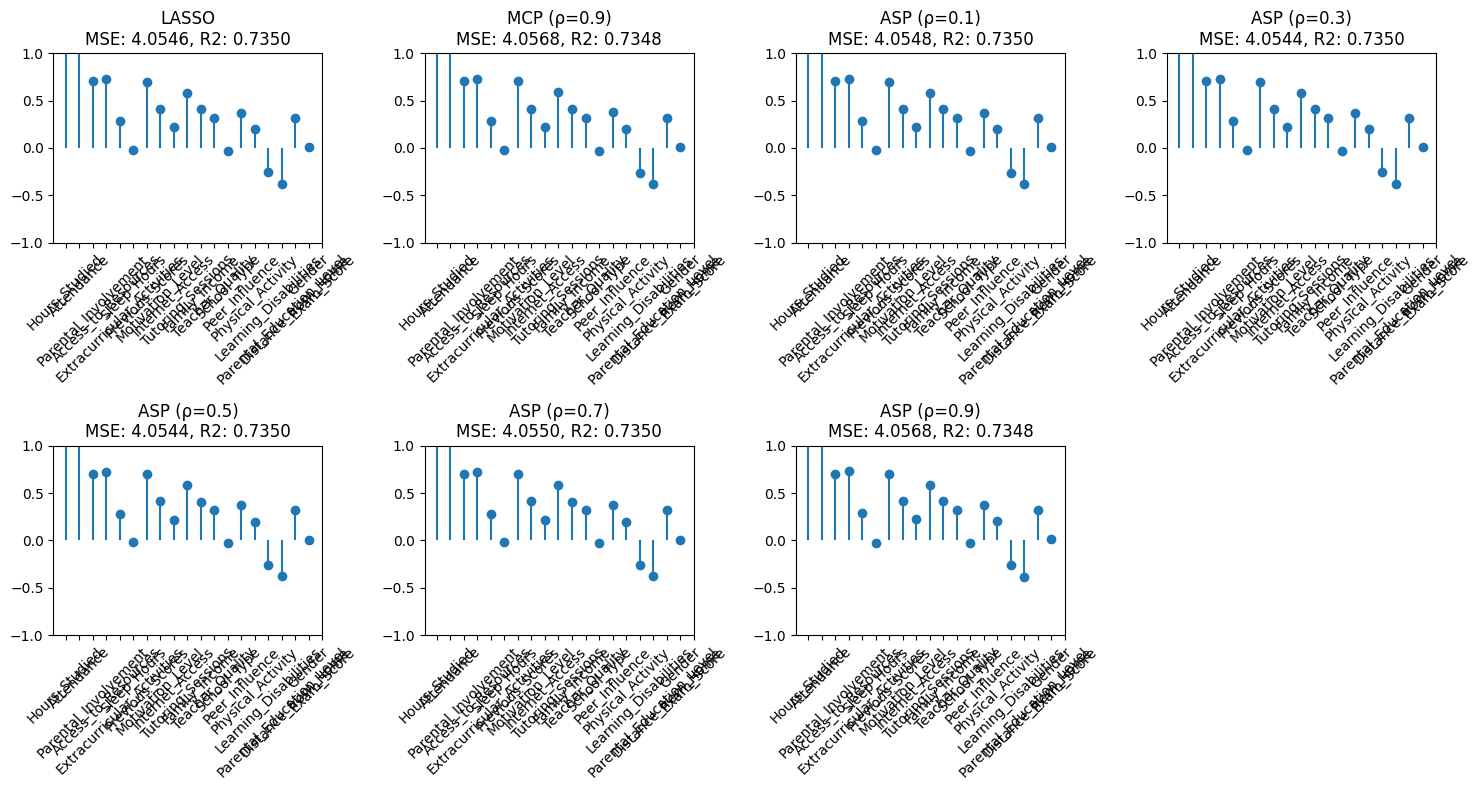

In [24]:
# Run the ML models with model evaluations
RealDataModelling('Exam_Score')